In [1]:
import numpy as np
import scipy as sc
import analysis as an
import beam_info as bi
import visual as vis
from openpmd_viewer import OpenPMDTimeSeries
import matplotlib.pyplot as plt

In [2]:
run_name = 'TUPPL/FACET_shift/30um_bunch/'
data = '5psi'
directory = '/Users/mengshutang/desktop/CU_PWFA/COMPUTATIONS/HiPACE/runs/'

ts = OpenPMDTimeSeries(directory + run_name + data + '/diags/hdf5')

tail_c = .3e-9
tot_c = 1.6e-9
dt = 1e-14
n0 = 1e16
iteration = 0

beam = bi.get_beam_info(ts = ts,beam = 'driver',iteration = iteration,tail_charge = tail_c,tot_charge = tot_c,dt = dt,num_bins = 100)

beam.print_beam_info(section = 'None')

Beam species: driver None
Distance traveled: 0.0 cm
Beam spot size: sig_x = 29.968 um; sig_y = 29.906 um.
Normalized emittance: eps_x = 35.211 um; eps_y = 35.109 um.
Twiss parameters: a_xy = 0.001,-0.002; b_xy = 0.499,0.499; g_xy = 2.003,2.006.


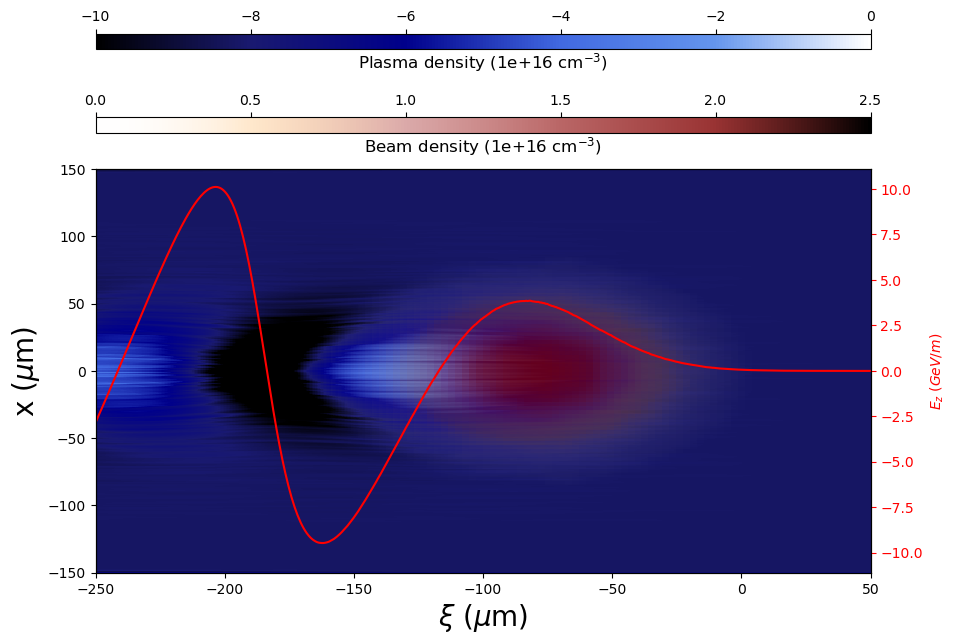

In [3]:
#----------------PWFA plot------------------
iteration = 2500

fig,ax = plt.subplots(1,1,figsize = (10,8))
ax.set_xlabel(r'$\xi$ ($\mu$m)',fontsize = 20)
ax.set_ylabel(r'x ($\mu$m)',fontsize = 20)

PWFA_plot = vis.visual(ts,iteration,n0)
PWFA_plot.plot_field(axes = ax,vmin = -10,plot_number_density = True)
PWFA_plot.plot_beam(beam_info = beam,plot_number_density = True,bin_y = True,axes = ax,vmax = 2.5)

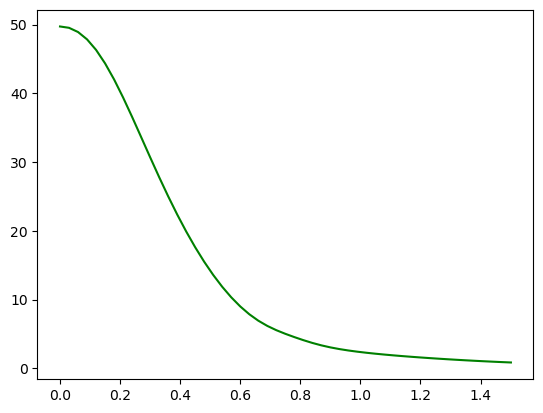

In [6]:
beam = bi.get_beam_info(ts = ts,beam = 'driver',iteration = iteration,tail_charge = .3e-9,tot_charge = tot_c,dt = dt,num_bins = 100)
plt_traj = vis.plot_trajectory(beam = beam)

plt_traj.bf_in_sims(section = 'tail',axes = None,color = color,linestyle = None,linewidth = None,label = f'{np.round(tail_charge*1e9,2)} nC')

58.920053005218506


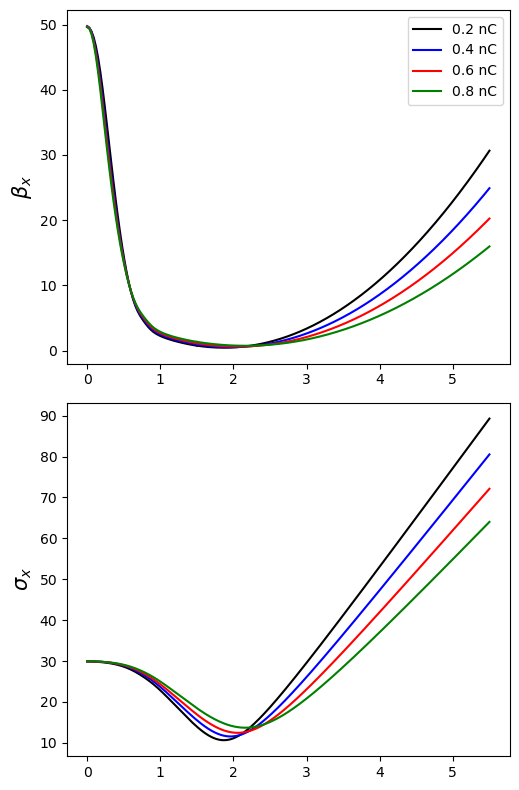

In [5]:
import time

start = time.time()

tail_charges = np.linspace(.2,.8,num = 4) * 1e-9
colors = ['k','b','r','g']
L = 4

fig,(ax1,ax2) = plt.subplots(2,1,figsize = (5,8))

for _ in range(len(tail_charges)):
    
    tail_charge = tail_charges[_]
    color = colors[_]
    
    beam = bi.get_beam_info(ts = ts,beam = 'driver',iteration = iteration,tail_charge = tail_charge,tot_charge = tot_c,dt = dt,num_bins = 100)

    plt_traj = vis.plot_trajectory(beam = beam)

    plt_traj.bf_in_sims(section = 'tail',axes = ax1,color = color,linestyle = None,linewidth = None,label = f'{np.round(tail_charge*1e9,2)} nC')

    plt_traj.bf_in_vac(L = L,section = 'tail',axes = ax1,color = color,linestyle = None,linewidth = None,label = None)

    plt_traj.full_beam_size_evln(L = L,section = 'tail',axes = ax2,color = color,linestyle = None,linewidth = None,label = None)

ax1.legend()
fig.tight_layout()
ax1.set_ylabel(r'$\beta_x$',fontsize = 15)
ax2.set_ylabel(r'$\sigma_x$',fontsize = 15)

end = time.time()
print(end - start)